In [1]:
%%writefile trajectories.py
import numpy as np
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

mini_batch_size = 128
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi

class Trajectories:

    def generate_train_test_trajects(self, type_traject):
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
        print(f'Is cuda available in trajectories.py?: {torch.cuda.is_available ()}')
        
        Xs_t = torch.zeros([type_traject,N_despl,N_coord], device=device) 
        y_t = torch.zeros([type_traject,N_despl,N_coord], device=device)
        y_inicial = torch.zeros([type_traject,N_coord], device=device)

#         Xs_t = Xs_t.to (device)
#         y_t = y_t.to (device)
#         y_inicial = y_inicial.to (device)
        
        print(f'Device cuda for y_inicial in trajectories.py:{y_inicial.is_cuda}')
        for k in range(type_traject):
            d360 = np.pi * 2
            ranX = np.zeros(N_despl)  
            des = np.ones(N_despl)*0.05

            for j in range(N_despl):
                if j == 0:
                    ranX[j] = float(np.random.uniform(0, d360, 1))
                else:
                    #ranX[j] = 0.95*ranX[j-1] + 0.05*(np.pi - float(np.random.uniform(0, d360, 1)))
                    ranX[j] = ranX[j-1] + float(np.random.uniform(-d360*0.1, d360*0.1, 1))


            cos = np.cos(ranX)

            sin = np.sin(ranX)

            ranY = []
            for i in range(len(cos)):
                ranY.append(des[i] / cos[i])

            Xak = []


            for i in range(len(ranX)):
                list1 = []
                list1.append(cos[i]*des[i])
                list1.append(sin[i]*des[i])
                Xak.append(list1)

            ylistk = []
            inicial = []

            for i in range(len(ranX)):
                coords = []
                if i == 0:
                    x_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][0]), limit_arena-np.abs(Xak[i][0]), 1))
                    y_cond_in = float(np.random.uniform(limit_arena2+np.abs(Xak[i][1]), limit_arena-np.abs(Xak[i][1]), 1))
                    coords.append(Xak[i][0] + x_cond_in)
                    coords.append(Xak[i][1] + y_cond_in)
                    ylistk.append(coords)  # posiciones iniciales en x e y
                    inicial.append(x_cond_in)
                    inicial.append(y_cond_in)
                else:
                    x_coord = cos[i]*des[i] + ylistk[i - 1][0]
                    y_coord = sin[i]*des[i] + ylistk[i - 1][1]
                    if limit_arena2 < y_coord < limit_arena and limit_arena2 < x_coord < limit_arena:
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif x_coord <= limit_arena2 or x_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    elif y_coord <= limit_arena2 or y_coord >= limit_arena:
                        x_coord = ylistk[i - 1][0]
                        y_coord = ylistk[i - 1][1]
                        cos[i:] = np.cos (ranX[i:] + grad_90)
                        sin[i:] = np.sin (ranX[i:] + grad_90)
                        coords.append (x_coord)
                        coords.append (y_coord)
                        ylistk.append (coords)
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord <= limit_arena2:
                    #     x_coord = limit_arena
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif x_coord >= limit_arena:
                    #     x_coord = limit_arena2
                    #     if y_coord < limit_arena2:
                    #         y_coord = limit_arena
                    #     if y_coord > limit_arena:
                    #         y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord <= limit_arena2:
                    #     y_coord = limit_arena
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)
                    # elif y_coord >= limit_arena:
                    #     y_coord = limit_arena2
                    #     coords.append(x_coord)
                    #     coords.append(y_coord)
                    #     ylistk.append(coords)


            Xsk = torch.tensor([Xak], device=device)
            yk = torch.tensor([ylistk], device=device)
            inicial = torch.tensor([inicial], device=device)

            y_inicial[k,:] = inicial
            Xs_t[k,:,:] = Xsk
            y_t[k,:,:] = yk

            
            Xs = Xs_t
            y = y_t      
            

        return Xs, y, y_inicial
print("trajectories")

Overwriting trajectories.py


In [2]:
%%writefile model.py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

N_despl = 2
N_hidden_neurons = 100
N_softmax_neurons = 50

class NeuralNetwork(nn.Module):
            
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.linear = nn.Linear(N_despl, N_hidden_neurons, bias=False) #probar otra inicializacion, xavier
        nn.init.xavier_uniform_(self.linear.weight, gain=0.9)
        self.Tanh = nn.ReLU() #logistica

        self.M = torch.randn((N_despl, N_hidden_neurons))*0.01
        self.M = torch.nn.Parameter(self.M)


        self.linear2 = nn.Linear(N_hidden_neurons, N_hidden_neurons)
        nn.init.orthogonal_(self.linear2.weight)
        self.Tanh2 = nn.ReLU()
        
        

        self.linear4 = nn.Linear(N_hidden_neurons, N_softmax_neurons)
        #nn.init.uniform_(self.linear4.weight, -1, 1)

        #self.dropout = nn.Dropout(0.25)

        self.softmax = nn.Softmax(dim=1)

        self.linear3 = nn.Linear(N_softmax_neurons, N_despl, bias=False)
        #nn.init.uniform_(self.linear3.weight, -1, 1)
        

    def forward(self, input, x0):
        

        
        xin = self.linear(input)

        u0 = self.Tanh(x0)
        xrec = self.linear2(u0)
        dx = (-x0 + xin + xrec) / 10 
        x1 = x0 + dx
        
        r = 0.4
        noise_linear2 = torch.randn(x1.size(), device='cuda:0')*r
        
        def add_noise(weights, noise):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
            weights.add_(noise)   
        
        add_noise(x1, noise_linear2) #acotar para que el ruido complique 
         
        x2 = self.Tanh(x1)
        x2c = torch.clamp(x2, min=None, max=1)

        #x1 = self.dropout(x1)
        
        x3 = self.linear4(x2c)
        beta = 1
        x4 = x3*beta
        x5 = self.softmax(x4)
        
        s = 0.1
        noise_linear3 = torch.randn(x5.size(), device='cuda:0')*s
        #add_noise(x5, noise_linear3)

        x6 = x5 + noise_linear3
        u1 = self.Tanh(x5)  
        yd = self.linear3(u1)
        

        return yd, x1, x3


Overwriting model.py


In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

from train import Training

mini_batch_size = 128 #intentar 32,64 
N_mini_batch = 130
total_traject = mini_batch_size * N_mini_batch
train_traject = int(total_traject * 0.7)
test_traject = int(total_traject * 0.3)
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi
print('done')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

trajectories
train
done


In [5]:
def distancia_modelo_real(tensor1, tensor2):
    x_distance = np.mean (np.abs ((tensor1[:, 0] - tensor2[:, 0])) / (np.max (tensor1[:, 0]) - np.min (tensor1[:, 0])))
    y_distance = np.mean (np.abs ((tensor1[:, 1] - tensor2[:, 1])) / (np.max (tensor1[:, 1]) - np.min (tensor1[:, 1])))
    return x_distance, y_distance
print('done')

done


In [6]:
%%writefile test.py
import numpy as np
import torch
import torch.nn as nn
from model import NeuralNetwork
from trajectories import Trajectories

mini_batch_size = 128
N_mini_batch = 130
test_traject = 256
N_despl = 20
N_coord = 2
limit_arena = 1
limit_arena2 = -1
grad_90 = np.pi
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 50

beta = 1

class Testing:

    def test_model(self):
        
        device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

        my_network = NeuralNetwork()
        my_network.to(device)
        my_network.M.to (device)
        
        
        mseloss = nn.MSELoss()
        optimizer = torch.optim.Adam(my_network.parameters(), lr = 0.01)
        
        traject = Trajectories()


        batch_y1 = torch.zeros(test_traject,N_despl,N_coord, device=device)
        y2 = torch.zeros(test_traject,N_despl,N_coord, device=device)
        
        all_activation_test = torch.zeros(test_traject, N_despl, N_hidden_neurons, device=device)
        all_activation_soft_test = torch.zeros(test_traject, N_despl, N_softmax_neurons, device=device)

        Xs, y, y_inicial = traject.generate_train_test_trajects(test_traject)

        my_network.eval()
        
        with torch.inference_mode():
            permutationX = torch.randperm(Xs.size()[0], device=device)
            test_batch = 128
            
            for i in range(0,Xs.size()[0], test_batch): #iterate minibatch

                activation = torch.zeros ((test_batch,N_despl, N_hidden_neurons), device=device)
                activation_soft = torch.zeros ((test_batch,N_despl, N_softmax_neurons), device=device)


                # remove current gradients for next iteration
                optimizer.zero_grad(set_to_none=True)
        
                firings = torch.zeros((test_batch, N_hidden_neurons), device=device)
                #firings = firings.to(device)
                firings_soft = torch.zeros((test_batch, N_softmax_neurons), device=device)
                #firings_soft = firings_soft.to(device)

                indicesX = permutationX[i:i + test_batch]
                batch_x, batch_y = Xs[indicesX], y[indicesX]
                batch_x = batch_x.to(device)
                vect = y_inicial[indicesX]
                vect = vect.cuda()
                
                x0 = vect@my_network.M
            
                ytotal = torch.zeros(test_batch,N_despl,2, device=device)
                for k in range(0, Xs.size()[1]):  # iterate time

                    # input training example and return the prediction
                    yhat, x0, x3 = my_network.forward(batch_x[:,k,:], x0)
                    ytotal[:,k,:] = yhat

                    firing = torch.relu(x0)
                    activation[:,k,:] = firing

                    firing2 = x3
                    firing2 *= beta
                    firing_soft = torch.softmax(firing2, dim=1)
                    activation_soft[:,k,:] = firing_soft

                batch_y1[i:i + test_batch,:,:] = batch_y.detach()
                y2[i:i + test_batch,:,:] = ytotal.detach()


                all_activation_test[i:i + test_batch,:,:] = activation.detach()
                all_activation_soft_test[i:i + test_batch,:,:] = activation_soft.detach()


                # calculate MSE loss
                # coef = 0.05
                loss1 = mseloss (ytotal, batch_y)
                # loss2 = firings_mean
                # loss = loss1 * (1 - coef) + loss2 * coef
                #
                # # append to loss
                # current_loss += loss
        return loss1, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network

Overwriting test.py


Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
loss = 0.30969876050949097
done
Hidden layer


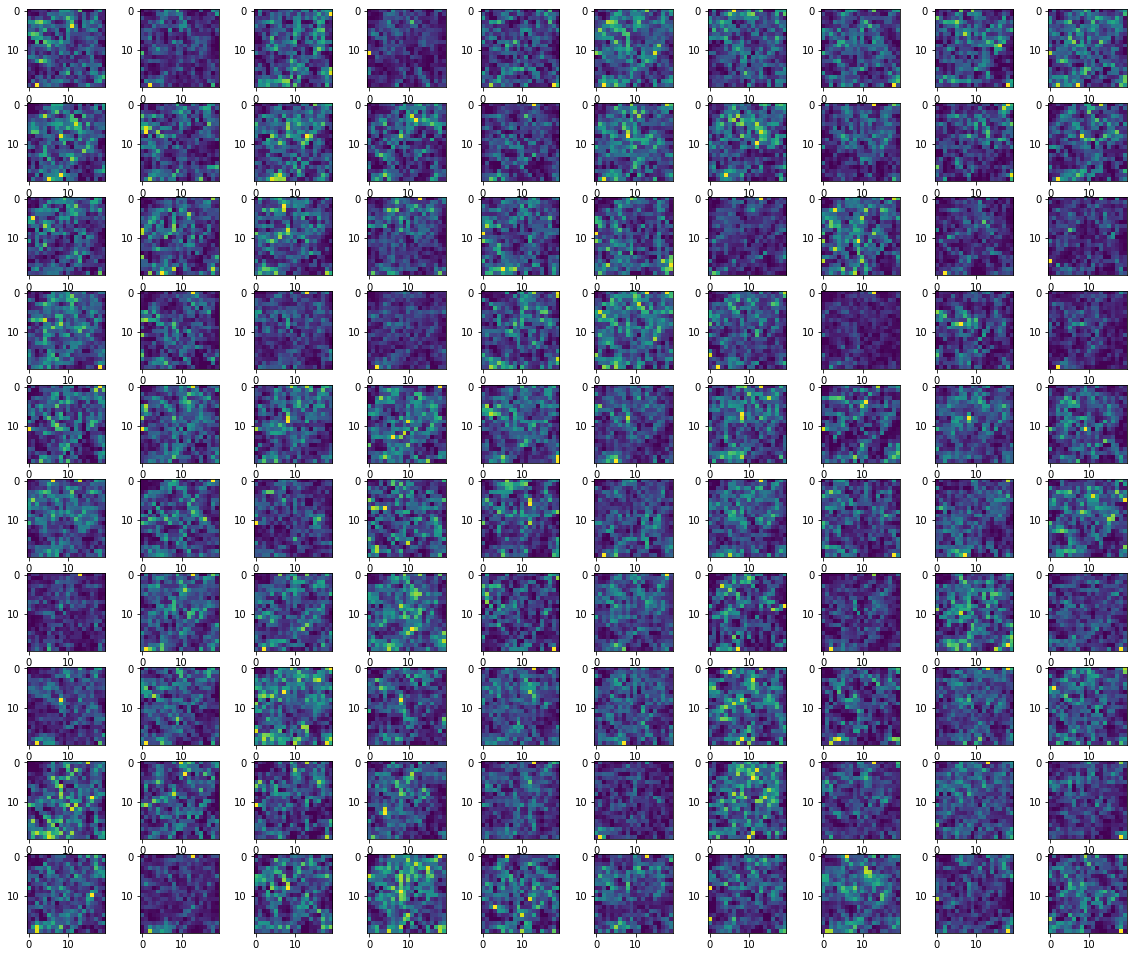

In [7]:
from test import Testing
N_despl = 20
N_coord = 2
N_hidden_neurons = 100
N_softmax_neurons = 50
test_traject = 256

t_traject = test_traject
        
test = Testing()
loss1, all_activation_test, all_activation_soft_test, batch_y1, y2, my_network  = test.test_model()

linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)


act_array_test = np.array(all_activation_test.cpu().detach().numpy())
act_array1 = np.reshape(act_array_test, [linear_size, N_hidden_neurons], order = 'C')

final_array = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1
    
print(f'loss = {loss1}')
print('done')

N_hidden_neurons = 100
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array[:,:,n])
print('Hidden layer')
plt.savefig('hidden_neurons.png')



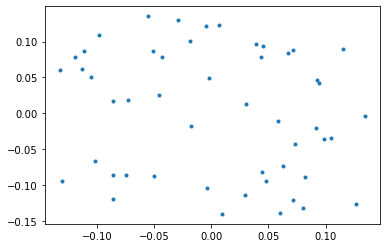

In [8]:

peso = my_network.linear3.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

In [9]:
import time
start_time = time.time()
t_traject = train_traject
## disable cudnn fixed the mem leak problem
torch.backends.cudnn.enabled = False
        
train = Training()
all_losses, all_activation, all_activation_soft, batch_y1, y2, my_network  = train.train_model()
#all_losses1, all_activation_soft
# fig, ax = plt.subplots (2, 2)
# ax[0, 0].plot (all_losses[1:], c='b', label='total')
# ax[0, 0].set_title ('total loss')
# ax[0, 1].plot (all_losses1[1:], c='g', label='MSEloss')
# ax[0, 1].set_title ('MSEloss')
# ax[1, 0].plot (all_losses2[1:], c='r', label='firing')
# ax[1, 0].set_title ('firing')
# plt.show ()

torch.save(my_network,'/kaggle/working/MyNetworkKaggle5.tar')

linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')
print('done')
timedelta = time.time() - start_time

print(f"The program took {timedelta} seconds to run")	

Is cuda available in train.py?: True
Is cuda available in trajectories.py?: True
Device cuda for y_inicial in trajectories.py:True
Device cuda for y_inicial in train.py:True
Device cuda for my_network :True
Epoch: 10 completed
4.119551628828049
added mem: 1901.69921875
Epoch: 20 completed
2.8060369193553925
added mem: 0.0
Epoch: 30 completed
2.3180710822343826
added mem: 0.0
Epoch: 40 completed
2.0200922284275293
added mem: 0.0
Epoch: 50 completed
1.6744645088911057
added mem: 0.0
Epoch: 60 completed
1.4950081631541252
added mem: 0.0
Epoch: 70 completed
1.3204972678795457
added mem: 0.0
Epoch: 80 completed
1.1704681273549795
added mem: 0.0
Epoch: 90 completed
1.025388970039785
added mem: 0.0
done
The program took 187.2506639957428 seconds to run


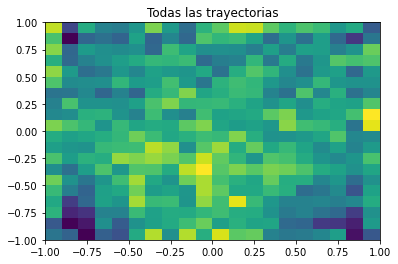

In [10]:
linear_size = t_traject * N_despl

data_x = batch_y1[:,:, 0].cpu().detach().numpy().T
data_y = batch_y1[:,:, 1].cpu().detach().numpy().T
# data[20,224] or [32,20] tiempo,N_traject


data_x = np.reshape(data_x, -1, order='F')
data_y = np.reshape(data_y, -1, order='F')

fig, ax = plt.subplots(1,1)
ax.hist2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
plt.title('Todas las trayectorias')
plt.savefig('all_trajects.png')
plt.show()

In [11]:
hist, *edges = np.histogram2d(data_x, data_y, bins=20, range=[[limit_arena2, limit_arena], [limit_arena2, limit_arena]])
inx = np.digitize(data_x, edges[0], right=True)
iny = np.digitize(data_y, edges[1], right=True)

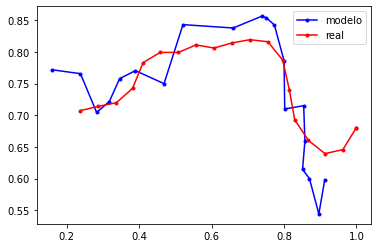

In [12]:
axisbins = list(zip(inx, iny))
axisbins = np.array(axisbins)

fig, ax = plt.subplots(1,1)
ax.plot(y2[-1,:,0].cpu().detach().numpy(), y2[-1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[-1,:,0].cpu().detach().numpy(), batch_y1[-1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.savefig('traject_example.png')
plt.show()

In [13]:
last_loss = all_losses[-1]
print(last_loss)

tensor(0.9515, device='cuda:0')


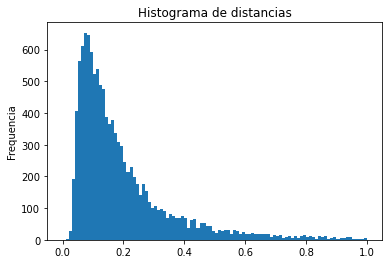

In [14]:
diferencia_array = np.zeros((2, y2[:,0,0].cpu().detach().numpy().size))

for i in range(y2[:,0,0].cpu().detach().numpy().size):
    x_dis, y_dis = distancia_modelo_real(y2[i, :, :].cpu().detach().numpy(), batch_y1[i, :, :].cpu().detach().numpy())
    diferencia_array[:,i] = [x_dis, y_dis]

plt.hist(diferencia_array[0,:], bins=100, range=[0, 1])
plt.gca().set(title='Histograma de distancias', ylabel='Frequencia')
plt.savefig('distance.png')
plt.show()

In [15]:
 N_hidden_neurons = 100


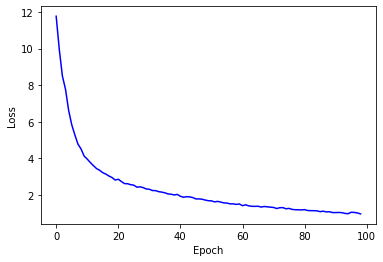

In [16]:
act_array = np.array(all_activation.cpu().detach().numpy())
act_array1 = np.reshape(act_array, [linear_size, N_hidden_neurons], order = 'C')

final_array = np.zeros([20,20,N_hidden_neurons])
counter = np.zeros([20,20])
counter = np.expand_dims(counter, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array[xbin-1,ybin-1,:] += act_array1[n,:]
    counter[xbin-1,ybin-1] += 1

plt.plot(all_losses[1:].cpu().detach().numpy(), c = 'b', label = 'total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('loss1.png')
plt.show()

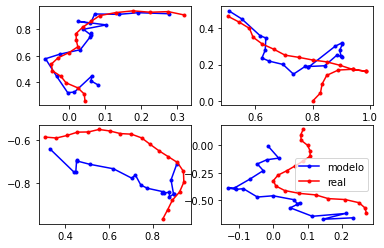

In [17]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

ax1.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax1.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax2.plot(y2[1,:,0].cpu().detach().numpy(), y2[1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax2.plot(batch_y1[1,:,0].cpu().detach().numpy(), batch_y1[1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax3.plot(y2[2,:,0].cpu().detach().numpy(), y2[2,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax3.plot(batch_y1[2,:,0].cpu().detach().numpy(), batch_y1[2,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax4.plot(y2[3,:,0].cpu().detach().numpy(), y2[3,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax4.plot(batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.savefig('traject_examples.png')

In [18]:
batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1]

(array([0.27236602, 0.2677206 , 0.25064597, 0.20994334, 0.16069137,
        0.12403199, 0.07607599, 0.03334543, 0.00697136, 0.00039455,
        0.01316047, 0.03961425, 0.06376202, 0.08689362, 0.10772501,
        0.10726667, 0.10019682, 0.08145894, 0.08019452, 0.08722642],
       dtype=float32),
 tensor([-0.6229, -0.5731, -0.5261, -0.4970, -0.4884, -0.4544, -0.4403, -0.4143,
         -0.3718, -0.3223, -0.2739, -0.2315, -0.1877, -0.1434, -0.0979, -0.0479,
          0.0016,  0.0479,  0.0979,  0.1474], device='cuda:0'))

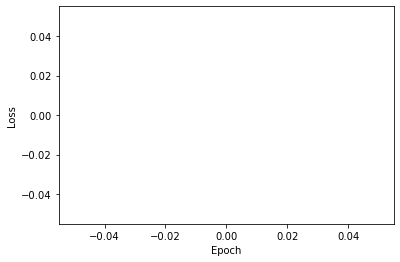

In [19]:
plt.plot(all_losses[500:].cpu().detach().numpy(), c = 'b', label = 'total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('loss.png')
plt.show()

In [20]:
act_array_soft = np.array(all_activation_soft.cpu().detach().numpy())
act_array_soft.shape

(11648, 20, 50)

In [21]:
N_softmax_neurons = 50
act_array_soft = np.array(all_activation_soft.cpu().detach().numpy())
act_array2 = np.reshape(act_array_soft, [linear_size, N_softmax_neurons], order = 'C')

final_array_soft = np.zeros([20,20,N_softmax_neurons])
counter_soft = np.zeros([20,20])
counter_soft = np.expand_dims(counter_soft, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array2[n,:]
    counter_soft[xbin-1,ybin-1] += 1
print('done')

done


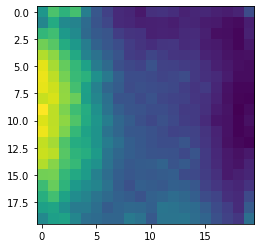

In [22]:
final_array = final_array / counter
final_array1 = final_array[:,:,0]
plt.imshow(final_array1)

Hidden layer


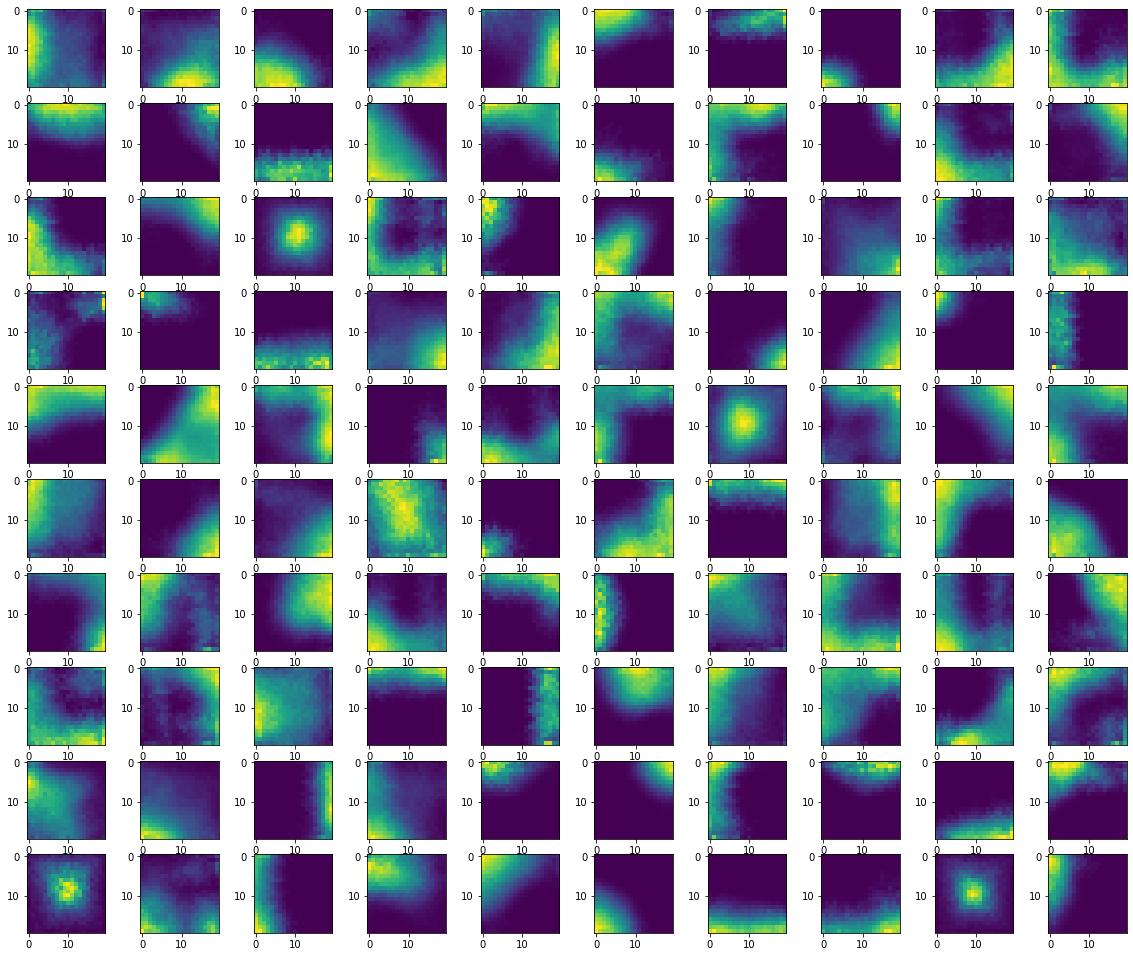

In [23]:
N_hidden_neurons = 100
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array[:,:,n])
print('Hidden layer')
plt.savefig('hidden_neurons.png')

#Var(Time, batch)   activaciones recurrente
#Ruido

#Mayor beta, ruido en la softmax también, =/= n° neuronas

Hidden layer


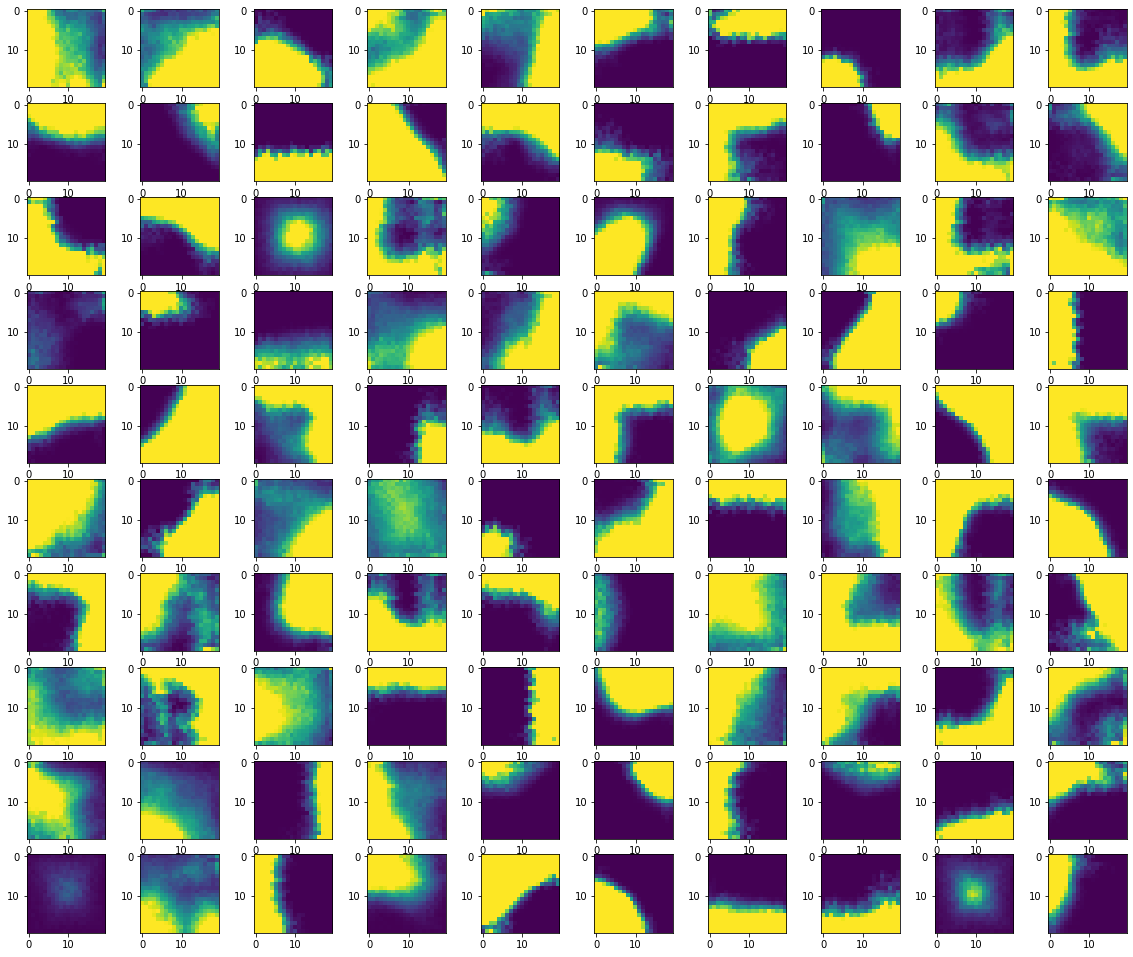

In [24]:
plt.figure(figsize=(20, 17))
for n in range(N_hidden_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array[:,:,n], vmin=0, vmax=1)
print('Hidden layer')



Softmax layer


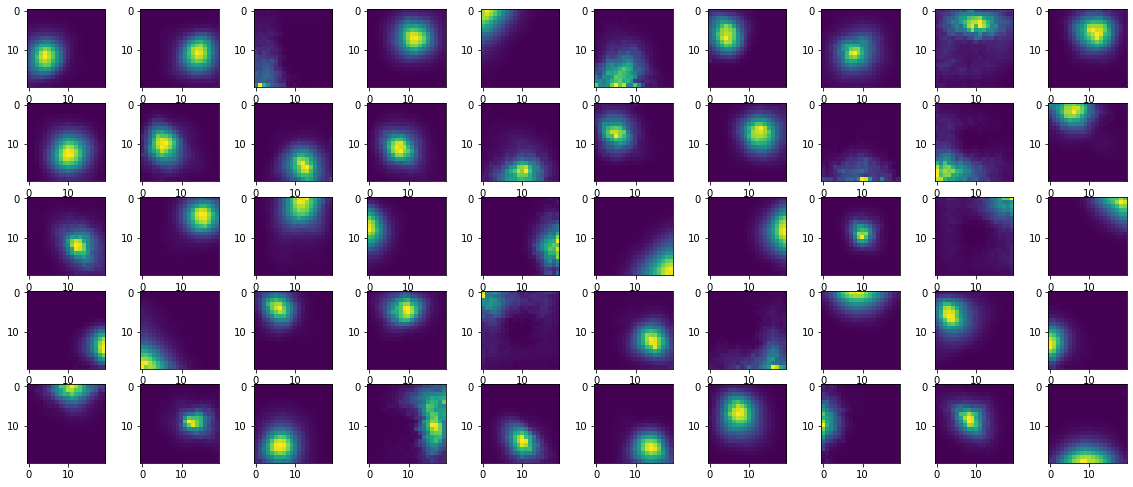

In [25]:
N_softmax_neurons = 50
final_array_soft = final_array_soft / counter_soft
final_array2 = final_array_soft[:,:,0]
plt.figure(figsize=(20, 17))
for n in range(N_softmax_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array_soft[:,:,n])
print('Softmax layer')
plt.savefig('softmax_neurons.png')

In [26]:
sum(final_array_soft[0,0,:])

0.9999999966501621

In [27]:
all_activation_soft.sum(2)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0')

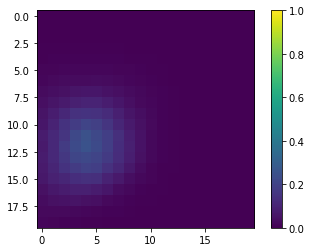

In [28]:
plt.imshow(final_array_soft[:,:,0], vmin=0, vmax=1)
plt.colorbar()


In [29]:
sum(final_array_soft[0,0,:])

0.9999999966501621

In [30]:
sum(counter_soft[0,0,:])

535.0

In [31]:
final_array_soft = np.zeros([20,20,N_softmax_neurons])
counter_soft = np.zeros([20,20])
counter_soft = np.expand_dims(counter_soft, 2)

for n in range(linear_size):
    xbin = axisbins[n,0]
    ybin = axisbins[n,1]
    final_array_soft[xbin-1,ybin-1,:] += act_array2[n,:]
    counter_soft[xbin-1,ybin-1] += 1
print('done')

done


Softmax layer


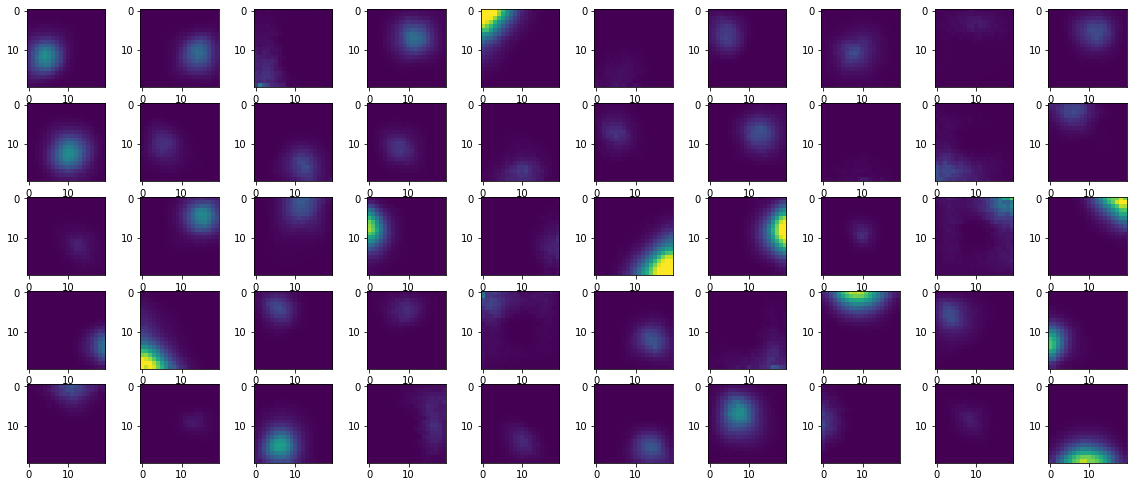

In [32]:
final_array_softmax = final_array_soft / counter_soft
plt.figure(figsize=(20, 17))
for n in range(N_softmax_neurons):
    ax = plt.subplot(10, 10, n + 1)
    ax.imshow(final_array_softmax[:,:,n], vmin=0, vmax=0.5)
print('Softmax layer')
plt.savefig('softmax_neurons1.png')


In [33]:
# plt.figure()
# final_array2 = np.log10(final_array_soft[:,:,0])
# plt.imshow(final_array2)
# plt.colorbar()

# plt.figure()
# final_array3 = np.log10(final_array_soft[:,:,1])
# plt.imshow(final_array3)
# plt.colorbar()
# print(np.max(np.abs(final_array_soft[:,:,0]-final_array_soft[:,:,1])))

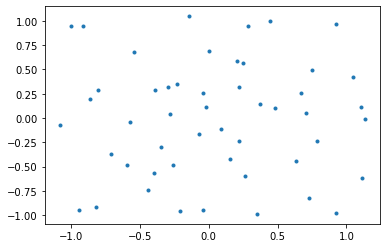

In [34]:
peso = my_network.linear3.weight
peso1 = peso.cpu().detach().numpy()
plt.plot(peso1.T[:,0], peso1.T[:,1], ".")

In [35]:
peso = my_network.linear3.weight
peso.T

tensor([[ 2.6075e-01, -5.9753e-01],
        [ 2.0585e-01,  5.8625e-01],
        [ 1.1144e+00, -6.1331e-01],
        [-2.9340e-01,  3.2051e-01],
        [-9.4594e-01, -9.4408e-01],
        [ 7.8262e-01, -2.3980e-01],
        [-4.0198e-01, -5.6550e-01],
        [ 8.8434e-02, -1.1012e-01],
        [-2.8426e-01,  3.8713e-02],
        [-3.8865e-01,  2.9028e-01],
        [ 3.7427e-01,  1.4677e-01],
        [ 1.5259e-01, -4.1945e-01],
        [ 6.7145e-01,  2.5516e-01],
        [ 2.2264e-01, -2.4108e-01],
        [ 7.0831e-01,  5.2416e-02],
        [-2.5866e-01, -4.8432e-01],
        [-2.3446e-01,  3.5214e-01],
        [ 1.1032e+00,  1.0821e-01],
        [ 7.2678e-01, -8.2403e-01],
        [-7.0882e-01, -3.6741e-01],
        [ 2.1999e-01,  3.2305e-01],
        [-5.4175e-01,  6.7995e-01],
        [-8.0818e-01,  2.9019e-01],
        [-2.0656e-01, -9.6274e-01],
        [ 2.8702e-01,  9.4390e-01],
        [ 9.2742e-01,  9.6334e-01],
        [-1.4184e-01,  1.0484e+00],
        [-1.8189e-02,  1.098

In [36]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[1,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[2,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[3,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

In [37]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())
# plt.colorbar(shrink=0.25)

# fig, ax = plt.subplots(1,1)
# ax.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()
# plt.show()

In [38]:
# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[0,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[1,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[2,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

# plt.figure(figsize=(20, 17))
# plt.imshow(np.log10(all_activation_soft[3,:,:].cpu().detach().numpy()))
# plt.colorbar(shrink=0.25)

In [39]:

# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

# ax1.plot(y2[0,:,0].cpu().detach().numpy(), y2[0,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax1.plot(batch_y1[0,:,0].cpu().detach().numpy(), batch_y1[0,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()

# ax2.plot(y2[1,:,0].cpu().detach().numpy(), y2[1,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax2.plot(batch_y1[1,:,0].cpu().detach().numpy(), batch_y1[1,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()

# ax3.plot(y2[2,:,0].cpu().detach().numpy(), y2[2,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax3.plot(batch_y1[2,:,0].cpu().detach().numpy(), batch_y1[2,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()

# ax4.plot(y2[3,:,0].cpu().detach().numpy(), y2[3,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax4.plot(batch_y1[3,:,0].cpu().detach().numpy(), batch_y1[3,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()
# plt.savefig('traject_examples.png')

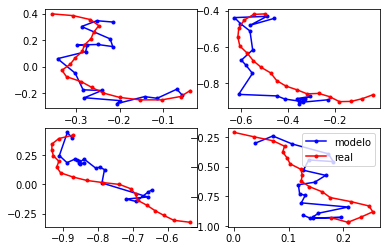

In [40]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

ax1.plot(y2[50,:,0].cpu().detach().numpy(), y2[50,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax1.plot(batch_y1[50,:,0].cpu().detach().numpy(), batch_y1[50,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax2.plot(y2[51,:,0].cpu().detach().numpy(), y2[51,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax2.plot(batch_y1[51,:,0].cpu().detach().numpy(), batch_y1[51,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax3.plot(y2[52,:,0].cpu().detach().numpy(), y2[52,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax3.plot(batch_y1[52,:,0].cpu().detach().numpy(), batch_y1[52,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

ax4.plot(y2[53,:,0].cpu().detach().numpy(), y2[53,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax4.plot(batch_y1[53,:,0].cpu().detach().numpy(), batch_y1[53,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()

In [41]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[1,:,:].cpu().detach().numpy())

In [42]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[5,:,:].cpu().detach().numpy())

In [43]:
# all_activation_soft[5,:,69].cpu().detach().numpy()

In [44]:
# fig, ax = plt.subplots(1,1)
# ax.plot(y2[5,:,0].cpu().detach().numpy(), y2[5,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
# ax.plot(batch_y1[5,:,0].cpu().detach().numpy(), batch_y1[5,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
# plt.legend()
# plt.show()

In [45]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[10,:,:].cpu().detach().numpy())

In [46]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[0,:,:].cpu().detach().numpy())

In [47]:
# plt.figure(figsize=(20, 17))
# plt.imshow(all_activation_soft[15,:,:].cpu().detach().numpy())

In [48]:
all_activation_soft

tensor([[[3.6848e-04, 2.1279e-01, 2.1082e-04,  ..., 3.5205e-04,
          6.5776e-03, 2.0114e-03],
         [8.1085e-04, 2.1405e-01, 5.7968e-06,  ..., 2.2292e-05,
          1.0633e-02, 2.9147e-03],
         [1.7879e-04, 2.6488e-01, 6.8542e-06,  ..., 3.3275e-05,
          1.4181e-02, 2.9705e-03],
         ...,
         [1.1046e-04, 3.0958e-02, 1.0422e-04,  ..., 6.4411e-05,
          9.4534e-05, 4.9156e-04],
         [9.3033e-05, 3.1913e-02, 6.9494e-05,  ..., 7.9625e-05,
          6.1626e-05, 9.0866e-04],
         [1.1372e-04, 3.2668e-02, 1.2809e-04,  ..., 1.8913e-04,
          4.5915e-05, 9.7411e-04]],

        [[7.3916e-04, 9.6171e-02, 4.6468e-05,  ..., 5.9363e-05,
          3.4194e-03, 2.3285e-02],
         [2.3031e-03, 1.5681e-01, 2.2013e-05,  ..., 3.6788e-04,
          5.5848e-03, 5.0949e-02],
         [5.5673e-03, 7.1631e-02, 3.6309e-06,  ..., 1.1505e-04,
          5.9616e-03, 6.7996e-02],
         ...,
         [2.0611e-04, 9.4997e-04, 2.0461e-04,  ..., 3.8145e-06,
          1.665

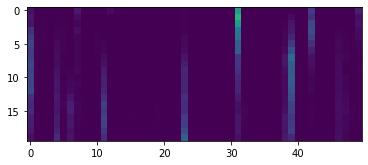

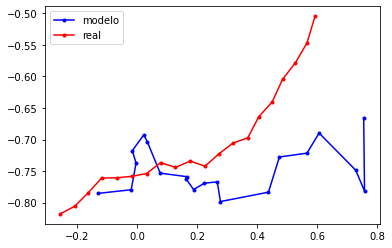

In [49]:
plt.imshow(all_activation_soft[20,:,:].cpu().detach().numpy(), vmin=0, vmax=1)
fig, ax = plt.subplots(1,1)
ax.plot(y2[20,:,0].cpu().detach().numpy(), y2[20,:,1].detach().cpu().numpy(), c = 'b', label = 'modelo', marker = '.')
ax.plot(batch_y1[20,:,0].cpu().detach().numpy(), batch_y1[20,:,1].cpu().detach().numpy(), c = 'r', label = 'real', marker = '.')
plt.legend()
plt.show()

In [50]:
all_activation_soft[20,:,[33,34]]

tensor([[6.8711e-07, 2.4522e-04],
        [5.1113e-07, 3.5982e-04],
        [1.8031e-06, 3.3273e-04],
        [1.6191e-05, 2.4697e-04],
        [3.2567e-05, 6.6898e-05],
        [1.5714e-04, 3.2248e-05],
        [2.6716e-04, 3.3717e-05],
        [9.7294e-04, 3.6884e-05],
        [2.1413e-04, 8.2384e-05],
        [2.0272e-04, 9.3109e-05],
        [2.6899e-04, 1.9233e-04],
        [2.2310e-04, 4.2801e-04],
        [2.3945e-04, 4.2325e-04],
        [6.9153e-04, 3.0249e-04],
        [2.0244e-03, 3.0000e-04],
        [3.8127e-03, 1.1192e-04],
        [3.1924e-03, 2.8678e-04],
        [1.6622e-03, 2.6477e-04],
        [1.1975e-03, 2.4128e-04],
        [1.3865e-03, 1.9262e-04]], device='cuda:0')

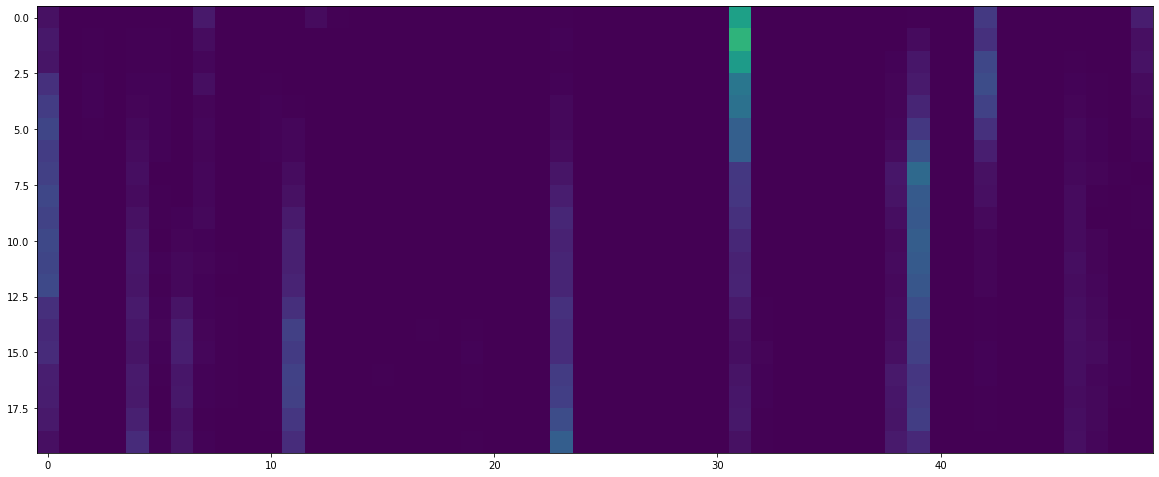

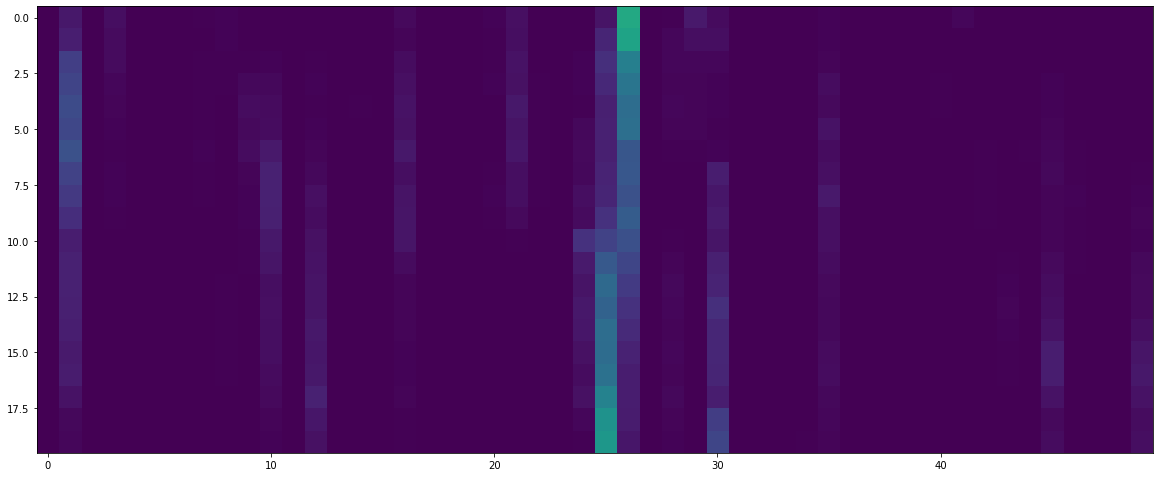

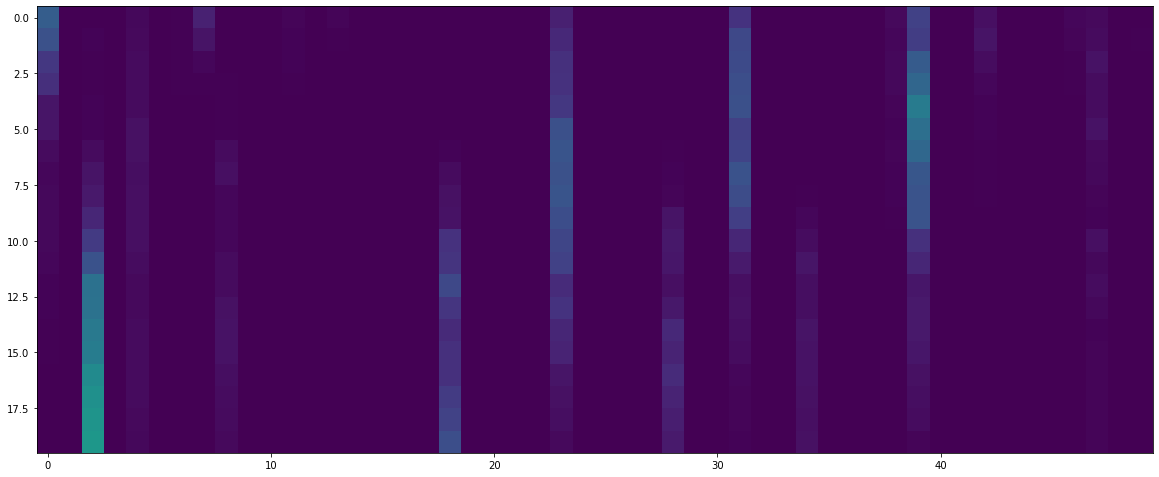

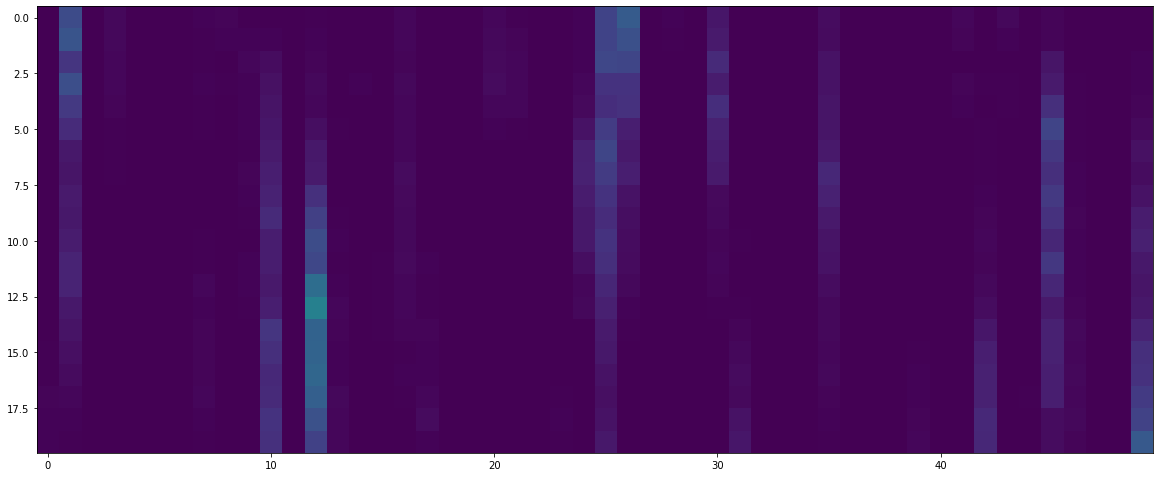

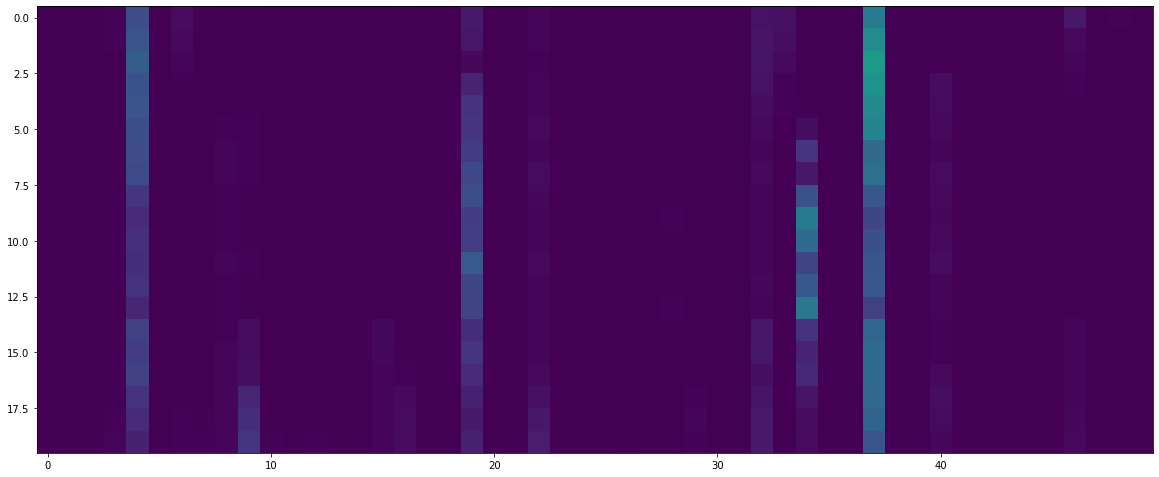

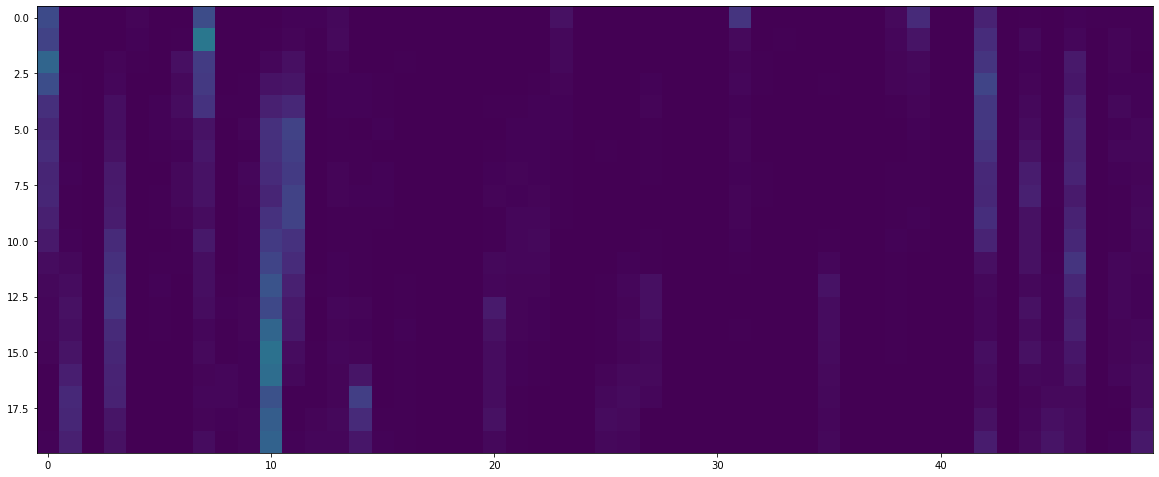

In [51]:
plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[20,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[21,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[22,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[23,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[24,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

plt.figure(figsize=(20, 17))
plt.imshow(all_activation_soft[25,:,:].cpu().detach().numpy(), vmin=0, vmax=1)

In [52]:
import torch
import torch.nn as nn
my_network = torch.load('/kaggle/input/bet17/MyNetworkKaggle5.tar')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/bet17/MyNetworkKaggle5.tar'